<a href="https://colab.research.google.com/github/KShrey00/Text_line_detection_model/blob/main/TextLineDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
import zipfile
import os

# Path to your .zip file in Drive
zip_path = '/content/dataset.zip'  # <- update if different

# Destination directory
extract_to = '/content/funsd_data'

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"✅ Unzipped to: {extract_to}")


✅ Unzipped to: /content/funsd_data


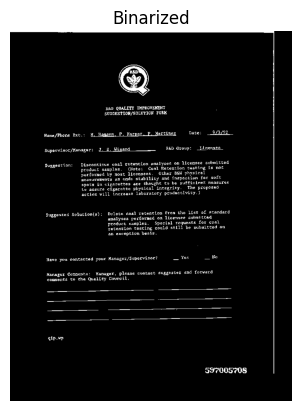

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def preprocess_image(img_path):
    if not os.path.exists(img_path):
        print(f"Error: Image file not found at {img_path}")
        return None

    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: Unable to load image from {img_path}")
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return binary

# Example:
# img_path = '/content/funsd_data/dataset/trainsing_data/images/660978.png'  # sample
img_path = '/content/funsd_data/dataset/dataset/training_data/images/0000971160.png'  # sample
binary_img = preprocess_image(img_path)

if binary_img is not None:
    plt.imshow(binary_img, cmap='gray')
    plt.title("Binarized")
    plt.axis('off')
    plt.show()

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_model(input_shape=(32, 128, 1)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [14]:
def sliding_window_detection(binary_img, model, win_size=(32, 128), stride=32, threshold=0.5):
    h, w = binary_img.shape
    boxes = []

    for y in range(0, h - win_size[0], stride):
        for x in range(0, w - win_size[1], stride):
            window = binary_img[y:y+win_size[0], x:x+win_size[1]]
            if window.shape != win_size:
                continue
            input_img = window.reshape(1, win_size[0], win_size[1], 1) / 255.0
            pred = model.predict(input_img, verbose=0)[0][0]
            if pred >= threshold:
                boxes.append((x, y, x + win_size[1], y + win_size[0]))
    return boxes


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


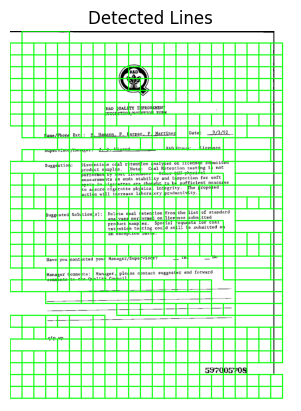

In [15]:
def draw_boxes(image, boxes):
    for (x1, y1, x2, y2) in boxes:
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return image

# Run detection and draw
original = cv2.imread(img_path)
binary_img = preprocess_image(img_path)
boxes = sliding_window_detection(binary_img, model=create_model(), stride=32)  # dummy model for now
output = draw_boxes(original.copy(), boxes)

plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("Detected Lines")
plt.axis("off")
plt.show()


In [16]:
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    if interArea == 0:
        return 0.0

    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    return interArea / float(boxAArea + boxBArea - interArea)

# Compare predicted_boxes vs ground_truth_boxes from JSON annotations
# Count TP, FP, FN based on IoU threshold
